In [15]:
import cv2
import pandas as pd
import numpy as np
import imutils
from imutils import perspective
from imutils import contours
from imageProcessing import resizeImg, generateMask
import joblib

%matplotlib inline
import matplotlib.pyplot as plt

In [16]:
# load the model from disk
filename = 'models/histgrad_model.sav'
loaded_model = joblib.load(filename)

In [101]:
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

def resizeImg(path):
    img = cv2.imread(path) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    max_val = 640
    w, h, channels = img.shape
    if h > 640 or w > 640:
        if h >= w:
            new_h = max_val
            new_w = (new_h/h)*w

        else:
            new_w = max_val
            new_h = (new_w/w)*h
            
        img = cv2.resize(img, (int(new_h), int(new_w)))
    
    return img

def getFeats(img,numfeats = 65):
    try:
        fft = np.log10(np.abs(np.fft.fft2(img)))
        w = fft.shape[0]//2
        fft = fft[3:w+3,3:w+3]
        feats = fft[:numfeats,:numfeats]
        q = np.hstack(feats)
        if len(q) != numfeats*numfeats:
            plt.imshow(img)
            print("Invalid face to get features")
            return None
        return q
    except:
        print("Cannot extract features")
        return None

def checkPicture(img):
    #img = cv2.imread(path) 
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Generate a mask
    mask = generateMask(img)
    background_mask = np.all(mask == [0, 0, 0], axis=-1)

    imarr = np.array(img)
    # Apply Mask / Separate Foreground and Background 
    foreground = imarr.copy()
    foreground[background_mask] = [0,0,0]
    plt.figure(figsize=(8,16))
    plt.subplot(1,2,1)
    plt.imshow(foreground,cmap="gray")
    
    img_bw = cv2.cvtColor(foreground, cv2.COLOR_RGB2GRAY)
    img_bw = cv2.GaussianBlur(img_bw, (7, 7), 1)
    
    res = loaded_model.predict([getFeats(img_bw)])
    print("Esta foto está:",res[0])
    
    return res[0],img,img_bw

def getContour(img_bw):
    edged = cv2.Canny(img_bw, 50, 100)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    #plt.subplot(1,3,2)
    #plt.imshow(edged,cmap="gray")
    
    
    # find contours in the edge map
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    #Get all contours and select the biggest one.
    (cnts, _) = contours.sort_contours(cnts)
    lst=[]
    for ind,c in enumerate(cnts):
        lst.append([ind,cv2.contourArea(c)])
    lst.sort(key=lambda lst: lst[1], reverse=True)
    c = cnts[lst[0][0]]
    
    return c
    
def getMeasures(img,c):
    # Compute the bounding box of the contour
    orig = img.copy()

    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(orig, (x, y), (x+w, y+h),(0, 255, 0), 2)
    box_points = [[x,y],[x,y+h],[x+w,y+h],[x+w,y]]
    new_box = np.array(box_points, dtype="int")
    print(new_box)
    
    '''
    # Min area rotated rectangle box, its necessary?
    box = cv2.minAreaRect(c)
    #print(box)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    print(box)
    box = np.array(box, dtype="int")
    
    
    # order the points in the contour such that they appear
    # in top-left, top-right, bottom-right, and bottom-left
    # order, then draw the outline of the rotated bounding box
    
    box = perspective.order_points(box)
    print(box)
    cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
    '''
    
    # loop over the original points and draw them
    for (x, y) in new_box:
        cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)
    
    
    # unpack the ordered bounding box, then compute the midpoint
    # between the top-left and top-right coordinates, followed by
    # the midpoint between bottom-left and bottom-right coordinates
    (tl, tr, br, bl) = new_box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)

    # compute the midpoint between the top-left and top-right points,
    # followed by the midpoint between the top-righ and bottom-right
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)

    # draw the midpoints on the image
    cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)

    # draw lines between the midpoints
    cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),(255, 0, 255), 2)
    cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),(255, 0, 255), 2)
    plt.subplot(1,2,2)
    plt.imshow(orig)
    
    
def obtainMeasures(path):
    img = resizeImg(path)
    res,img,img_bw = checkPicture(img)
    
    if res == "OK":
        c = getContour(img_bw)
        getMeasures(img,c)
        return res
    else:
        print("The image is not valid.")

Esta foto está: OK
[[123  20]
 [123 619]
 [308 619]
 [308  20]]


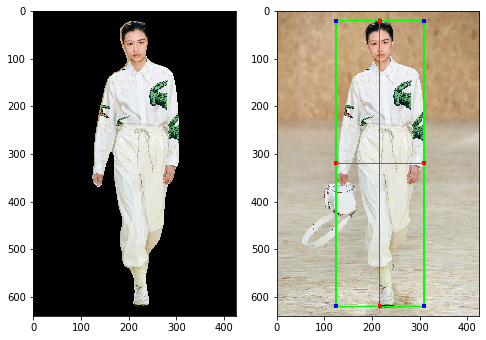

In [102]:
measure = obtainMeasures("../inputs/images/People_Yes_fullHD/OK_000008.jpg")

Esta foto está: OK
[[108  15]
 [108 624]
 [298 624]
 [298  15]]


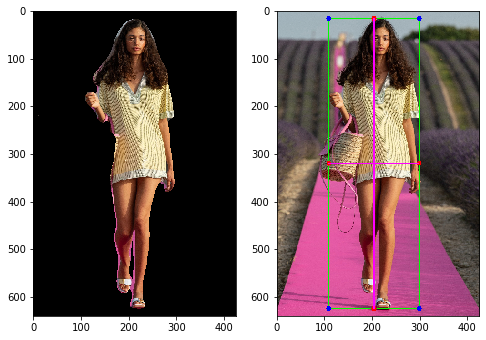

In [103]:
measure = obtainMeasures("../inputs/images/People_Yes_fullHD/OK_000405.jpg")

Esta foto está: OK
[[148  32]
 [148 628]
 [345 628]
 [345  32]]


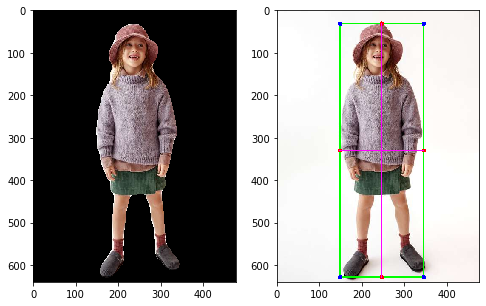

In [104]:
p="../inputs/images/Posture_Yes/modelo1.jpg"
measure = obtainMeasures(p)

Esta foto está: KO
The image is not valid.


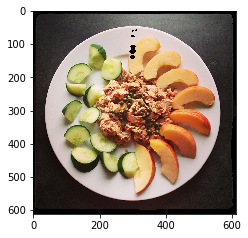

In [108]:
p="../inputs/images/People_No/000000138954.jpg"
measure = obtainMeasures(p)

Esta foto está: OK
[[165  51]
 [165 607]
 [311 607]
 [311  51]]


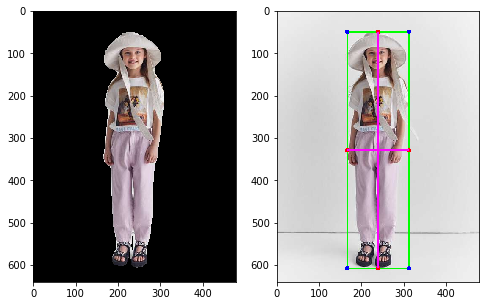

In [107]:
p="../inputs/images/Posture_Yes/modelo13.jpg"
measure = obtainMeasures(p)